# HW6
## Yidan Wang 2973331278

### 2. Active Learning Using Support Vector Machines

#### (a) Download the banknote authentication Data Set Choose 472 data points randomly as the test set, and the remaining 900 points as the training set. This is a binary classification problem.

1. variance of Wavelet Transformed image (continuous)
2. skewness of Wavelet Transformed image (continuous)
3. curtosis of Wavelet Transformed image (continuous)
4. entropy of image (continuous)
5. class (integer)

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

raw_data = pd.read_csv('../data/data_banknote_authentication.txt', header=None)

x_data = raw_data.iloc[:,:-1]
y = raw_data.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(x_data, y, test_size=0.344, random_state=424, stratify=y)

#### (b) Repeat each of the following two procedures 50 times. You will have 50 errors for 90 SVMs per each procedure.

#### i. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the penalty parameter using 5-fold cross validation. Repeat this process by adding 10 other randomly selected data points to the pool, until you use all the 900 points. Do NOT replace the samples back into the training set at each step. Calculate the test error for each SVM. You will have 90 SVMs that were trained using 10, 20, 30, ... , 900 data points and their 90 test errors. You have implemented passive learning

In [35]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV


res = pd.DataFrame()
for m in range(0,50):
    train = pd.concat([X_train, y_train], axis=1)
    test_error_list = []
    train_new = pd.DataFrame()
    for i in range(0,90):
        selected_data = train.sample(n=10, replace=False, random_state=m, axis=0)
        s_index_list = selected_data.index.tolist()
        
        train_new = train_new.append(selected_data)
        train.drop(s_index_list, inplace=True) 
        
        svm = LinearSVC(penalty="l1",dual=False, max_iter=10000)
        param_grid = {'C':np.logspace(-3, 6, 10)}
        grid = GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)
        
        grid.fit(train_new.iloc[:,:-1], train_new.iloc[:,-1])
        y_pred= grid.predict(X_test)
        test_error = 1 - grid.score(X_test, y_test)
        test_error_list.append(test_error)
    
    res[m]=test_error_list


In [100]:
columns_name = [x*10 for x in range(1,91)]
res2 = res.T
res2.columns = columns_name
avg_res = res2.mean()
avg = avg_res.to_frame()
avg.columns = ["avg of 50 times test error of passive learning"]
display(avg)

,avg of 50 times test error of passive learning
10,0.135085
20,0.070042
30,0.044831
40,0.035085
50,0.027246
...,...
860,0.005254
870,0.005551
880,0.005508
890,0.005551


#### ii. Train a SVM with a pool of 10 randomly selected data points from the training set using linear kernel and L1 penalty. Select the parameters of the SVM with 5-fold cross validation. Choose the 10 closest data points in the training set to the hyperplane of the SVM and add them to the pool. Do not replace the samples back into the training set. Train a new SVM using the pool. Repeat this process until all training data is used. You will have 90 SVMs that were trained using 10, 20, 30,..., 900 data points and their 90 test errors. You have implemented active learning.

In [94]:
res_2 = pd.DataFrame()
for m in range(0,50):
    train = pd.concat([X_train, y_train], axis=1)
    test_error_list = []
    train_new = pd.DataFrame()
    for i in range(0, 90):
        if i == 0:
            selected_data = train.sample(n=10, replace=False, random_state=m, axis=0)
            if selected_data[4].nunique() == 1:
                print("rechoose")
                selected_data = train.sample(n=10, replace=False, random_state=m+50, axis=0)
            s_index_list = selected_data.index.tolist()
            
            train_new = train_new.append(selected_data)
            train.drop(s_index_list, inplace=True) 
            
            train = train.values
            train_new = train_new.values
        
        svm = LinearSVC(penalty="l1",dual=False, max_iter=10000)
        param_grid = {'C':np.logspace(-3, 6, 10)}
        grid_2 = GridSearchCV(svm, param_grid=param_grid, cv=5, n_jobs=-1)
        grid_2.fit(train_new[:,:-1], train_new[:,-1])
        
        if train.size !=0:
            dis = grid.decision_function(train[:,:-1])
            if dis.shape[0] == 10:
                close_points = range(0,10)
            else:
                close_points = np.argpartition(abs(dis), 10)[:10]
            selected_data = train[close_points]
            train_new = np.vstack((train_new, selected_data))
            train = np.delete(train, close_points, axis = 0)
        
        y_pred= grid_2.predict(X_test)
        test_error = 1 - grid_2.score(X_test, y_test)
        test_error_list.append(test_error)
        
    res_2[m]=test_error_list



In [102]:
res_22 = res_2.T
res_22.columns = columns_name
avg_res2 = res_22.mean()
avg2 = avg_res2.to_frame()
avg2.columns = ["avg of 50 times test error of activate learning"]
display(avg2)

,avg of 50 times test error of activate learning
10,0.133475
20,0.126653
30,0.065297
40,0.044619
50,0.006356
...,...
860,0.004237
870,0.004237
880,0.004237
890,0.004237


#### (c) Average the 50 test errors for each of the incrementally trained 90 SVMs in 2(b)i and 2(b)ii. By doing so, you are performing a Monte Carlo simulation. Plot average test error versus number of training instances for both active and passive learners on the same figure and report your conclusions. Here, you are actually obtaining a learning curve by Monte-Carlo simulation.

In [103]:
avg_fin = pd.concat([avg,avg2],axis=1)
avg_fin

,avg of 50 times test error of passive learning,avg of 50 times test error of activate learning
10,0.135085,0.133475
20,0.070042,0.126653
30,0.044831,0.065297
40,0.035085,0.044619
50,0.027246,0.006356
...,...,...
860,0.005254,0.004237
870,0.005551,0.004237
880,0.005508,0.004237
890,0.005551,0.004237


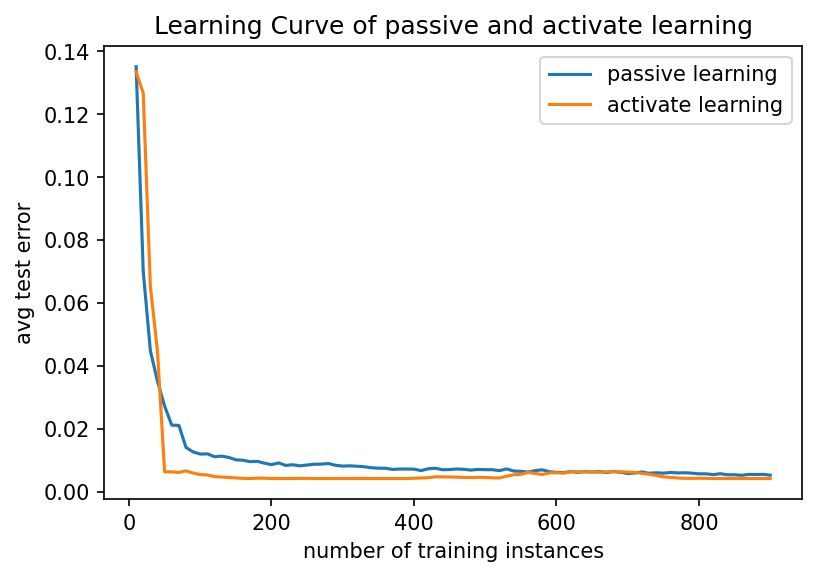

In [106]:
plt.figure(dpi=150)
plt.plot(columns_name, avg, label='passive learning');
plt.plot(columns_name, avg2, label='activate learning');
plt.title("Learning Curve of passive and activate learning")
plt.xlabel('number of training instances')
plt.ylabel('avg test error')
plt.legend();